In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.5`
import $ivy.`org.apache.spark::spark-mllib:2.4.5`
import $ivy.`org.apache.spark::spark-streaming:2.4.5`
import $ivy.`org.apache.spark::spark-streaming-kafka-0-10:2.4.5`
import $ivy.`org.apache.spark::spark-sql-kafka-0-10:2.4.5`

import $ivy.$                                  

import $ivy.$                                    

import $ivy.$                                        

import $ivy.$                                                   

import $ivy.$                                             

In [2]:
import sys.process._

import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)

import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._

import org.apache.spark.ml.feature.{HashingTF, IDF, Tokenizer, VectorAssembler}
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.classification.LogisticRegression
import org.apache.spark.ml.classification.{RandomForestClassificationModel, RandomForestClassifier}

import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator

import org.apache.spark.sql.streaming.Trigger
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.SparkSession

def killAll() = {
    SparkSession
        .active
        .streams
        .active
        .foreach { x =>
                    val desc = x.lastProgress.sources.head.description
                    x.stop
                    println(s"Stopped ${desc}")
        }               
}

import sys.process._


import org.apache.log4j.{Level, Logger}

import org.apache.spark.sql._

import org.apache.spark.sql.functions._

import org.apache.spark.sql.types._


import org.apache.spark.ml.feature.{HashingTF, IDF, Tokenizer, VectorAssembler}

import org.apache.spark.ml.{Pipeline, PipelineModel}

import org.apache.spark.ml.regression.LinearRegression

import org.apache.spark.ml.classification.LogisticRegression

import org.apache.spark.ml.classification.{RandomForestClassificationModel, RandomForestClassifier}


import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator


import org.apache.spark.sql.streaming.Trigger

import org.apache.spark.sql.DataFrame

import org.apache.spark.sql.SparkSession


defined function killAll

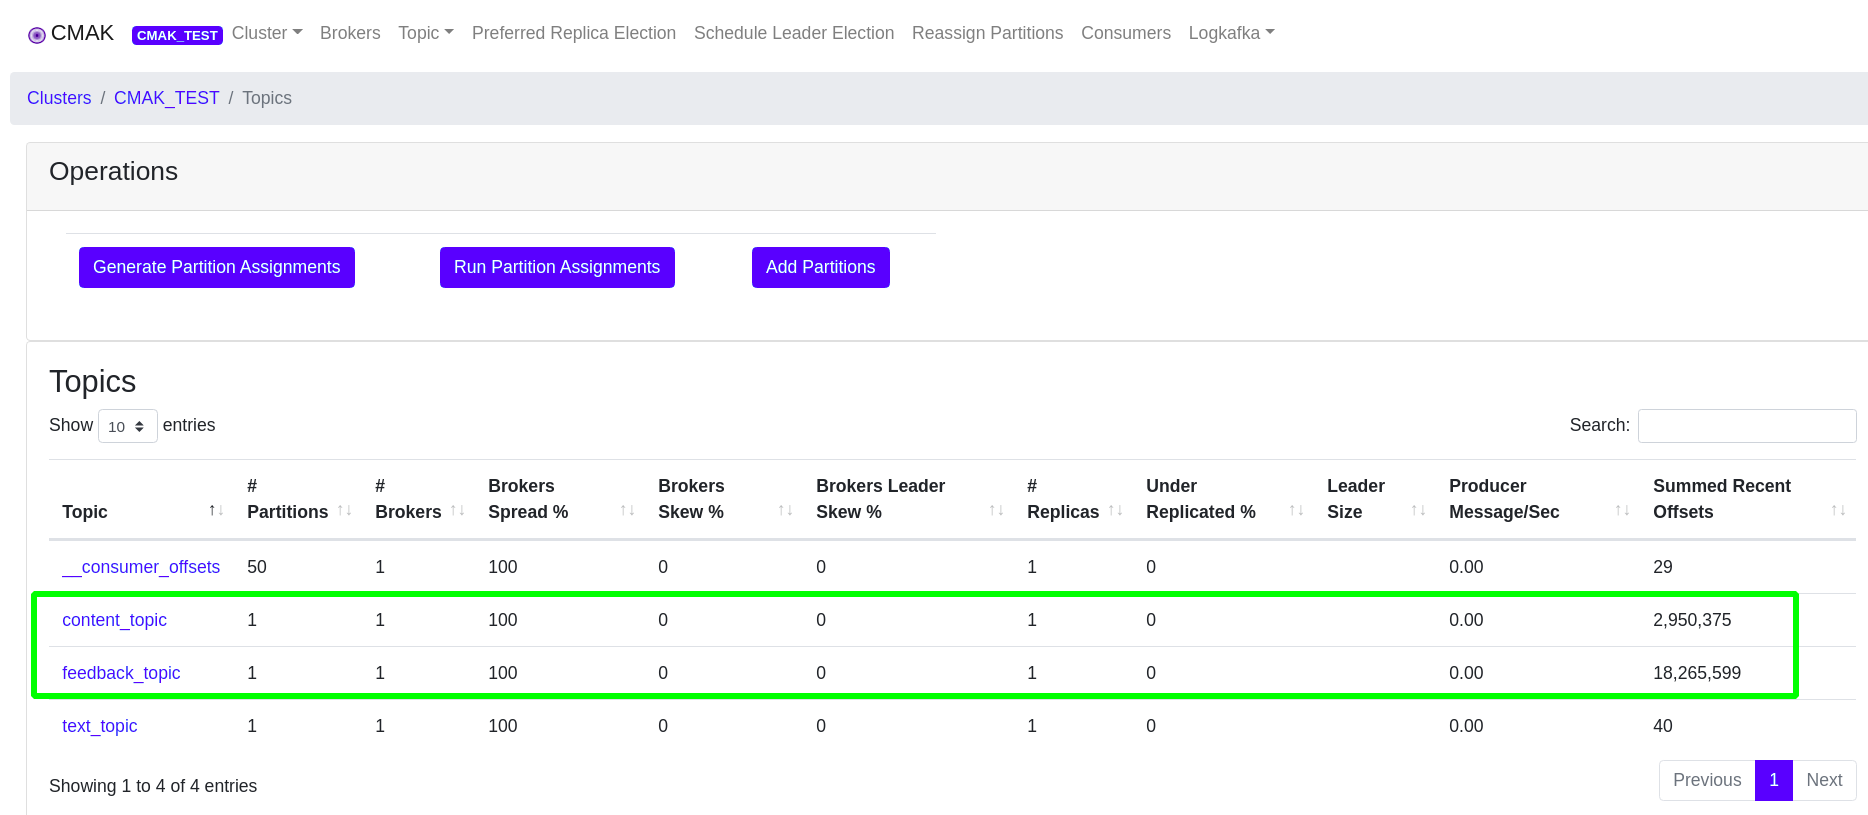

In [3]:
val spark = {
  NotebookSparkSession.builder()
    .master("local[*]")
    .config("spark.executor.instances", "2")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
}

import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

spark: SparkSession = org.apache.spark.sql.SparkSession@55992cae
import spark.implicits._

In [38]:
spark.sparkContext.uiWebUrluiWebUrl

res37: Option[String] = Some("http://774cd6601c93:4040")

In [4]:
// Подгрузим json-структуру из соответствующих примеров экземпляров json-файлов, которые были ранее сохранены 

val df_content_temp = spark.read.json("../data/processed/stg_content_test/content_test.json")
val df_feedback_temp = spark.read.json("../data/processed/stg_feedback_test/feedback_test.json")

val content_value_schema = df_content_temp.schema.filter(x=>x.name == "value").map(x=>x.dataType).asInstanceOf[Seq[types.DataType]](0)
val feedback_value_schema = df_feedback_temp.schema.filter(x=>x.name == "value").map(x=>x.dataType).asInstanceOf[Seq[types.DataType]](0)


json at cmd3.sc:1

1 / 1

json at cmd3.sc:2

1 / 1

df_content_temp: DataFrame = [key: string, timestamp: bigint ... 1 more field]
df_feedback_temp: DataFrame = [key: string, timestamp: bigint ... 1 more field]
content_value_schema: DataType = StructType(
  StructField("applicationId", LongType, true, {}),
  StructField("authorId", LongType, true, {}),
  StructField("numCompanions", LongType, true, {}),
  StructField("numPhotos", LongType, true, {}),
  StructField("numPolls", LongType, true, {}),
  StructField("numSymbols", LongType, true, {}),
  StructField("numTokens", LongType, true, {}),
  StructField("numVideos", LongType, true, {}),
  StructField("objectType", StringType, true, {}),
  StructField("options", ArrayType(StringType, true), true, {}),
  StructField("ownerId", LongType, true, {}),
  StructField("ownerType", StringType, true, {}),
  StructField("platform", StringType, true, {}),
  StructField("totalVideoLength", LongType, true, {})
)
feedback_value_schema: DataType = StructType(
  StructField("feedback", ArrayType(String

<br><br> **Потестируем захват стримов на синхронизации с консолью - TEST mode - CONSOLE sink**

#### STREAM 01: CONTENT (Test, Console Sink)

In [5]:
val df_content = (spark
  .readStream
  .format("kafka")
  .option("kafka.bootstrap.servers", "172.27.1.16:9092")
  .option("subscribe", "content_topic_test")
  .option("enable.auto.commit", "false")
  .option("auto.commit.interval.ms", "31536000000")
  .option("auto.offset.reset", "earliest")
  .option("startingOffsets", "earliest")
  .option("maxOffsetsPerTrigger", "500")
  .load()
  )
// val sink = createConsoleSink(df_content)

def createConsoleSink(df: DataFrame) = {
    df
    .writeStream
    .format("console")
    .trigger(Trigger.ProcessingTime("10 seconds"))
    .option("truncate", "true")
    .option("numRows", "10")
}

val df_content_proc = (
    df_content
    .select(
        $"offset" as "rowNum",
        $"timestamp" as "contentTS" ,
        $"key" cast "string" as "objID", 
        from_json($"value" cast "string", content_value_schema) as "content_struct"
    )
    .select($"rowNum", $"contentTS", $"objID", $"content_struct.*")
    .select($"rowNum", $"contentTS", $"objID", $"objectType", $"options")
)

val sink = createConsoleSink(df_content_proc)
val sq = sink.start()

sq.awaitTermination(60000)

-------------------------------------------
Batch: 0
-------------------------------------------
+------+---------+-----+----------+-------+
|rowNum|contentTS|objID|objectType|options|
+------+---------+-----+----------+-------+
+------+---------+-----+----------+-------+



start at cmd4.sc:37

1 / 1

-------------------------------------------
Batch: 1
-------------------------------------------
+------+-------------------+--------+----------+--------------------+
|rowNum|          contentTS|   objID|objectType|             options|
+------+-------------------+--------+----------+--------------------+
|     0|2018-01-01 00:05:13|16876204|      Post|[HAS_PHOTOS, IS_P...|
|     1|2018-01-01 00:16:41|  289803|     Video|[HAS_TEXT, HAS_VI...|
|     2|2018-01-01 00:34:09|18216307|      Post|[HAS_TEXT, HAS_PH...|
|     3|2018-01-01 00:55:04|14853939|      Post|[HAS_PHOTOS, HAS_...|
|     4|2018-01-01 01:24:05|24063312|      Post|[HAS_TEXT, HAS_PH...|
|     5|2018-01-01 01:48:53| 1500033|     Photo|[IS_PART_OF_ALBUM...|
|     6|2018-01-01 01:50:12|26239217|      Post|[HAS_TEXT, HAS_PH...|
|     7|2018-01-01 01:55:04|13555535|      Post|[HAS_TEXT, HAS_PH...|
|     8|2018-01-01 01:56:02|14314539|      Post|[HAS_TEXT, HAS_PH...|
|     9|2018-01-01 01:56:05|15682524|      Post|[HAS_TEXT, HAS_

start at cmd4.sc:37

1 / 1

-------------------------------------------
Batch: 2
-------------------------------------------
+------+-------------------+--------+----------+--------------------+
|rowNum|          contentTS|   objID|objectType|             options|
+------+-------------------+--------+----------+--------------------+
|   500|2018-01-01 21:41:32|  298239|     Video|[HAS_TEXT, HAS_VI...|
|   501|2018-01-01 21:42:19|  543925|     Video|[HAS_TEXT, HAS_VI...|
|   502|2018-01-01 21:45:04|38762132|      Post|[HAS_TEXT, HAS_PH...|
|   503|2018-01-01 21:51:06|17221510|      Post|[HAS_PHOTOS, IS_P...|
|   504|2018-01-01 21:51:27|14716505|      Post|[HAS_TEXT, HAS_PH...|
|   505|2018-01-01 21:52:52| 2678420|     Photo|  [IS_PART_OF_ALBUM]|
|   506|2018-01-01 22:01:03| 3038104|     Photo|[IS_PART_OF_ALBUM...|
|   507|2018-01-01 22:02:43|  687920|     Video|[HAS_TEXT, HAS_VI...|
|   508|2018-01-01 22:10:05|31116008|      Post|[HAS_TEXT, HAS_PH...|
|   509|2018-01-01 22:12:33|12061203|      Post|[HAS_TEXT, HAS_

df_content: DataFrame = [key: binary, value: binary ... 5 more fields]
defined function createConsoleSink
df_content_proc: DataFrame = [rowNum: bigint, contentTS: timestamp ... 3 more fields]
sink: streaming.DataStreamWriter[Row] = org.apache.spark.sql.streaming.DataStreamWriter@3eae8048
sq: streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@2015efd4
res4_5: Boolean = false

In [6]:
killAll()

Stopped KafkaV2[Subscribe[content_topic_test]]


#### STREAM 02: FEEDBACK (Test, Console Sink)

In [7]:

val df_feedback = spark
  .readStream
  .format("kafka")
  .option("kafka.bootstrap.servers", "172.27.1.16:9092")
  .option("subscribe", "feedback_topic_test") ////////////////////
  .option("enable.auto.commit", "false")
  .option("auto.commit.interval.ms", "31536000000")
  .option("auto.offset.reset", "earliest")
  .option("startingOffsets", "earliest")
  .option("maxOffsetsPerTrigger", "1500")
  .load()

def createConsoleSink(df: DataFrame) = {
    df
    .writeStream
    .format("console")
    .trigger(Trigger.ProcessingTime("10 seconds"))
    .option("truncate", "true")
    .option("numRows", "10")
}

val df_feedback_proc = (
    df_feedback
    .select(
        $"offset" as "rowNum",
        $"timestamp" as "feedbackTS" ,
        split($"key", "_").getItem(0) as "useID", 
        split($"key", "_").getItem(1) as "objID", 
        from_json($"value" cast "string", feedback_value_schema) as "feedback_struct")
    .select(
        $"rowNum",
        $"feedbackTS",
        $"useID", 
        $"objID", 
        $"feedback_struct.feedback" as "feedback" // $"feedback_struct.*"
    )
)

val sink = createConsoleSink(df_feedback_proc)
val sq = sink.start()

sq.awaitTermination(60000)

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----------+-----+-----+--------+
|rowNum|feedbackTS|useID|objID|feedback|
+------+----------+-----+-----+--------+
+------+----------+-----+-----+--------+



start at cmd6.sc:40

1 / 1

-------------------------------------------
Batch: 1
-------------------------------------------
+------+--------------------+--------+--------+--------------------+
|rowNum|          feedbackTS|   useID|   objID|            feedback|
+------+--------------------+--------+--------+--------------------+
|     0|2018-02-18 11:57:...|10486914|  304539|           [Clicked]|
|     1|2018-02-24 15:09:...|11248422|14838919|           [Ignored]|
|     2|2018-02-06 17:26:...|11972100|22599605|           [Ignored]|
|     3|2018-03-03 13:17:...|14952438|12465334|             [Liked]|
|     4|2018-03-13 02:46:...|15279759|  304539|           [Ignored]|
|     5|2018-02-17 18:29:...| 2252610|  304539|           [Ignored]|
|     6|2018-02-21 15:59:...| 2780709|11322902|           [Ignored]|
|     7|2018-02-06 22:11:...|  305451|  290443|           [Ignored]|
|     8|2018-02-03 07:56:...| 3137910|16196712|[Clicked, Liked, ...|
|     9|2018-02-15 00:39:...| 3169221|12681913|           [Ignored]|
+-----

start at cmd6.sc:40

1 / 1

-------------------------------------------
Batch: 2
-------------------------------------------
+------+--------------------+--------+--------+----------------+
|rowNum|          feedbackTS|   useID|   objID|        feedback|
+------+--------------------+--------+--------+----------------+
|  1500|2018-02-23 14:50:...| 8790714|  687920|       [Ignored]|
|  1501|2018-02-14 15:08:...|   91890|25512032|       [Ignored]|
|  1502|2018-03-16 17:49:...|10356465| 9814817|[Clicked, Liked]|
|  1503|2018-02-02 08:50:...| 1040082|12840612|       [Ignored]|
|  1504|2018-03-05 17:34:...|11169663|12972000|[Clicked, Liked]|
|  1505|2018-02-17 13:48:...|11443104|  304539|       [Clicked]|
|  1506|2018-02-07 06:17:...|11468919|17013940|         [Liked]|
|  1507|2018-02-01 13:31:...|14752203|25512032|       [Ignored]|
|  1508|2018-02-26 19:34:...| 4191006|  296720|       [Clicked]|
|  1509|2018-02-28 16:27:...| 5471700|  330303|       [Ignored]|
+------+--------------------+--------+--------+-----------

df_feedback: DataFrame = [key: binary, value: binary ... 5 more fields]
defined function createConsoleSink
df_feedback_proc: DataFrame = [rowNum: bigint, feedbackTS: timestamp ... 3 more fields]
sink: streaming.DataStreamWriter[Row] = org.apache.spark.sql.streaming.DataStreamWriter@521ac3f8
sq: streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@5d102118
res6_5: Boolean = false

In [8]:
killAll()

Stopped KafkaV2[Subscribe[feedback_topic_test]]


#### STATIC DF: USERINFO (Test, parquet, Cache, need .unpersist)

In [9]:
val df_userinfo_test = (
    spark.read.parquet("../data/processed/stg_userinfo/userinfo.parquet").withColumnRenamed("userId","useID")
    .join(
    spark.read.json("../data/processed/stg_feedback_test/*.json").select(split($"key", "_").getItem(0) as "useID").distinct,
    Seq("useID")
    )
    .cache
)

df_userinfo_test.count()
df_userinfo_test.show(5)

// df_userinfo_test.unpersist()

parquet at cmd8.sc:2

1 / 1

json at cmd8.sc:4

1 / 1

run at ThreadPoolExecutor.java:1149

1 / 1

run at ThreadPoolExecutor.java:1149

200 / 200

count at cmd8.sc:10

4 / 4

count at cmd8.sc:10

1 / 1

show at cmd8.sc:11

1 / 1

show at cmd8.sc:11

3 / 3

+-----+-------------+----------+------+------+-----------+-----------+---------+----------+---------+------------+-------------+----------------+------+
|useID|  create_date|birth_date|gender|status| ID_country|ID_Location|is_active|is_deleted|is_abused|is_activated|change_datime|is_semiactivated|region|
+-----+-------------+----------+------+------+-----------+-----------+---------+----------+---------+------------+-------------+----------------+------+
| 4023|1177483791220|     -8038|     2|   192|10414533690|    2784685|        1|         0|        0|           1|1446452587253|               0|    13|
| 8466|1179416081833|      2317|     1|   192|10397571399|    3204080|        1|         0|        0|           1|1445518076457|               0|   101|
|17352|1165503003607|     -6017|     1|   192|10399393757|    2896892|        1|         0|        0|           1|1512901008927|               0|   170|
|25473|1160377838493|      2388|     2|   192|10414533690|    3385314|        1|  

df_userinfo_test: Dataset[Row] = [useID: int, create_date: bigint ... 12 more fields]
res8_1: Long = 2797L

#### STREAM 01 + STREAM 02 + STATIC DF (Test, Console Sink, Left Join, Need Watermark)

In [10]:
val kafkaConsumerConf = Map(
    "kafka.bootstrap.servers" -> "172.27.1.16:9092",
    "enable.auto.commit"      -> "false",
    "auto.commit.interval.ms" -> "31536000000",
    "auto.offset.reset"       -> "earliest",
    "startingOffsets"         -> "earliest"
)

def get_kafka_stream(
    sparkSession: org.apache.spark.sql.SparkSession, 
    kafkaConsumerConf: Map[String, String],
    topicName: String,
    maxOffsets: Int) = 
{
    sparkSession
    .readStream
    .format("kafka")
    .options(kafkaConsumerConf)
    .option("subscribe", topicName)
    .option("maxOffsetsPerTrigger", maxOffsets.toString)
    .load()

}

kafkaConsumerConf: Map[String, String] = Map(
  "auto.offset.reset" -> "earliest",
  "auto.commit.interval.ms" -> "31536000000",
  "enable.auto.commit" -> "false",
  "kafka.bootstrap.servers" -> "172.27.1.16:9092",
  "startingOffsets" -> "earliest"
)
defined function get_kafka_stream

In [11]:

val df_feedback_stream = get_kafka_stream(spark, kafkaConsumerConf, "feedback_topic_test", 2000)
val df_feedback = df_feedback_stream
.select(
    $"offset" as "rowNum1", 
    $"timestamp" as "feedback_TS", 
    split($"key", "_").getItem(0) as "feedback_useID", 
    split($"key", "_").getItem(1) as "feedback_objID", 
    from_json($"value" cast "string", feedback_value_schema) as "feedback_struct"
)
.select($"rowNum1", $"feedback_TS", $"feedback_useID", $"feedback_objID", $"feedback_struct.*")
.select($"rowNum1", $"feedback_TS", $"feedback_useID", $"feedback_objID", $"feedback")
.withWatermark("feedback_TS", "3 months") // "30 seconds"


val df_content_stream = get_kafka_stream(spark, kafkaConsumerConf, "content_topic_test", 1000)
val df_content = df_content_stream
.select(
    $"offset" as "rowNum2",
    $"timestamp" as "content_TS",
    $"key" cast "string" as "content_objID", 
    from_json($"value" cast "string", content_value_schema) as "content_struct"
    )
.select($"rowNum2", $"content_TS", $"content_objID", $"content_struct.*")
.select($"rowNum2", $"content_TS", $"content_objID", $"objectType", $"options")
.withWatermark("content_TS", "3 months") // "30 seconds"


val joinCond1 = (
    df_feedback("feedback_objID") === df_content("content_objID") && 
    df_feedback("feedback_TS").geq(df_content("content_TS")) && 
    df_feedback("feedback_TS").leq(df_content("content_TS") + expr("interval 3 months"))
)

val joinCond2 = (
    df_feedback("feedback_useID") === df_userinfo_test("useID") && 
    df_feedback("feedback_TS").geq(df_content("content_TS")) && 
    df_feedback("feedback_TS").leq(df_content("content_TS") + expr("interval 3 months"))
)

val joinCond3 = (
    df_feedback("feedback_useID") === df_userinfo_test("useID")
)

val df_join = (
    df_feedback
    .join(
        df_content, 
        joinCond1, 
        "left") // inner, if left, needs watermark
    .filter("content_objID is not null")
    .join(
        df_userinfo_test.select($"useID", $"birth_date", $"gender"), 
        joinCond3, 
        "inner") // inner, if left, needs watermark
    .filter("useID is not null") 
)
// .groupBy().count()


df_feedback_stream: DataFrame = [key: binary, value: binary ... 5 more fields]
df_feedback: Dataset[Row] = [rowNum1: bigint, feedback_TS: timestamp ... 3 more fields]
df_content_stream: DataFrame = [key: binary, value: binary ... 5 more fields]
df_content: Dataset[Row] = [rowNum2: bigint, content_TS: timestamp ... 3 more fields]
joinCond1: Column = (((feedback_objID = content_objID) AND (feedback_TS >= content_TS)) AND (feedback_TS <= (content_TS + interval 3 months)))
joinCond2: Column = (((feedback_useID = useID) AND (feedback_TS >= content_TS)) AND (feedback_TS <= (content_TS + interval 3 months)))
joinCond3: Column = (feedback_useID = useID)
df_join: Dataset[Row] = [rowNum1: bigint, feedback_TS: timestamp ... 11 more fields]

<br><br> **Попробуем заджойнить два стрима - TEST mode - CONSOLE sink**
<br>https://databricks.com/blog/2018/03/13/introducing-stream-stream-joins-in-apache-spark-2-3.html

In [12]:
def createConsoleSink(df: DataFrame) = {
    df
    .writeStream
    .format("console")
    .trigger(Trigger.ProcessingTime("10 seconds"))
    .option("truncate", "true")
    .option("numRows", "10")
}

val sink = createConsoleSink(df_join)
val sq = sink.start()
sq.awaitTermination(60000)

start at cmd11.sc:11

4 / 4

start at cmd11.sc:11

200 / 200

-------------------------------------------
Batch: 0
-------------------------------------------
+-------+-----------+--------------+--------------+--------+-------+----------+-------------+----------+-------+-----+----------+------+
|rowNum1|feedback_TS|feedback_useID|feedback_objID|feedback|rowNum2|content_TS|content_objID|objectType|options|useID|birth_date|gender|
+-------+-----------+--------------+--------------+--------+-------+----------+-------------+----------+-------+-----+----------+------+
+-------+-----------+--------------+--------------+--------+-------+----------+-------------+----------+-------+-----+----------+------+



start at cmd11.sc:11

4 / 4

start at cmd11.sc:11

1 / 1

start at cmd11.sc:11

1 / 1

start at cmd11.sc:11

200 / 200

-------------------------------------------
Batch: 1
-------------------------------------------
+-------+--------------------+--------------+--------------+----------------+-------+-------------------+-------------+----------+--------------------+--------+----------+------+
|rowNum1|         feedback_TS|feedback_useID|feedback_objID|        feedback|rowNum2|         content_TS|content_objID|objectType|             options|   useID|birth_date|gender|
+-------+--------------------+--------------+--------------+----------------+-------+-------------------+-------------+----------+--------------------+--------+----------+------+
|   3206|2018-02-17 13:31:...|       2567736|      26473500|       [Ignored]|   1577|2018-01-02 04:15:15|     26473500|      Post|[HAS_TEXT, HAS_PH...| 2567736|      2531|     2|
|   4343|2018-02-06 12:06:...|       5344344|      10918519|         [Liked]|   1786|2018-01-02 11:18:41|     10918519|      Post|[HAS_TEXT, HAS_PH...| 5344344|      2032|     2|
|   2435

start at cmd11.sc:11

4 / 4

start at cmd11.sc:11

1 / 1

start at cmd11.sc:11

1 / 1

start at cmd11.sc:11

200 / 200

-------------------------------------------
Batch: 2
-------------------------------------------
+-------+--------------------+--------------+--------------+-----------------+-------+-------------------+-------------+----------+--------------------+--------+----------+------+
|rowNum1|         feedback_TS|feedback_useID|feedback_objID|         feedback|rowNum2|         content_TS|content_objID|objectType|             options|   useID|birth_date|gender|
+-------+--------------------+--------------+--------------+-----------------+-------+-------------------+-------------+----------+--------------------+--------+----------+------+
|   4635|2018-02-08 14:29:...|       1379637|       1370701|[Clicked, Viewed]|   1362|2018-01-01 16:36:05|      1370701|     Photo|[HAS_TEXT, IS_PAR...| 1379637|     -2916|     1|
|   4635|2018-02-08 14:29:...|       1379637|       1370701|[Clicked, Viewed]|   1362|2018-01-01 16:36:05|      1370701|     Photo|[HAS_TEXT, IS_PAR...| 1379637|     -2916|     1|
|  

defined function createConsoleSink
sink: streaming.DataStreamWriter[Row] = org.apache.spark.sql.streaming.DataStreamWriter@1cdf6138
sq: streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@7e5db4b9
res11_3: Boolean = false

In [13]:
killAll()

Stopped KafkaV2[Subscribe[feedback_topic_test]]


<br><br> **Попробуем заджойнить два стрима - TEST mode - PARQUET sink - без ограничений на количество полей**

In [14]:
val df_feedback_stream = get_kafka_stream(spark, kafkaConsumerConf, "feedback_topic_test", 3000)
val df_feedback = df_feedback_stream
.select(
    $"offset" as "rowNum1", 
    $"timestamp" as "feedback_TS", 
    split($"key", "_").getItem(0) as "feedback_useID", 
    split($"key", "_").getItem(1) as "feedback_objID", 
    from_json($"value" cast "string", feedback_value_schema) as "feedback_struct"
)
.select($"rowNum1", $"feedback_TS", $"feedback_useID", $"feedback_objID", $"feedback_struct.*")
// .select($"rowNum1", $"feedback_TS", $"feedback_useID", $"feedback_objID", $"feedback")
.withWatermark("feedback_TS", "3 months") // "30 seconds"


val df_content_stream = get_kafka_stream(spark, kafkaConsumerConf, "content_topic_test", 1000)
val df_content = df_content_stream
.select(
    $"offset" as "rowNum2",
    $"timestamp" as "content_TS",
    $"key" cast "string" as "content_objID", 
    from_json($"value" cast "string", content_value_schema) as "content_struct"
    )
.select($"rowNum2", $"content_TS", $"content_objID", $"content_struct.*")
// .select($"rowNum2", $"content_TS", $"content_objID", $"objectType", $"options")
.withWatermark("content_TS", "3 months") // "30 seconds"


val joinCond1 = (
    df_feedback("feedback_objID") === df_content("content_objID") && 
    df_feedback("feedback_TS").geq(df_content("content_TS")) && 
    df_feedback("feedback_TS").leq(df_content("content_TS") + expr("interval 3 months"))
)

val joinCond2 = (
    df_feedback("feedback_useID") === df_userinfo_test("useID") && 
    df_feedback("feedback_TS").geq(df_content("content_TS")) && 
    df_feedback("feedback_TS").leq(df_content("content_TS") + expr("interval 3 months"))
)

val joinCond3 = (
    df_feedback("feedback_useID") === df_userinfo_test("useID")
)

val df_join = (
    df_feedback
    .join(
        df_content, 
        joinCond1, 
        "left") // inner, if left, needs watermark
    .filter("content_objID is not null")
    .join(
        df_userinfo_test, //.select($"useID", $"birth_date", $"gender"), 
        joinCond3, 
        "inner") // inner, if left, needs watermark
    .filter("useID is not null") 
)


df_feedback_stream: DataFrame = [key: binary, value: binary ... 5 more fields]
df_feedback: Dataset[Row] = [rowNum1: bigint, feedback_TS: timestamp ... 4 more fields]
df_content_stream: DataFrame = [key: binary, value: binary ... 5 more fields]
df_content: Dataset[Row] = [rowNum2: bigint, content_TS: timestamp ... 15 more fields]
joinCond1: Column = (((feedback_objID = content_objID) AND (feedback_TS >= content_TS)) AND (feedback_TS <= (content_TS + interval 3 months)))
joinCond2: Column = (((feedback_useID = useID) AND (feedback_TS >= content_TS)) AND (feedback_TS <= (content_TS + interval 3 months)))
joinCond3: Column = (feedback_useID = useID)
df_join: Dataset[Row] = [rowNum1: bigint, feedback_TS: timestamp ... 35 more fields]

In [15]:
"rm -rf ../data/checkpoint/df_join_test" !

res14: Int = 0

In [16]:
"rm -rf ../data/parquet/df_join_test" !

res15: Int = 0

In [17]:
def createParquetSink(df: DataFrame, fileName: String, procTime: String) = {
    df
    .writeStream
    .format("parquet")
    .option("path", s"../data/parquet/$fileName")
    .option("checkpointLocation", s"../data/checkpoint/$fileName")
    .trigger(Trigger.ProcessingTime(procTime))
}

val sink = createParquetSink(df_join, "df_join_test", "60 seconds")
val sq = sink.start()
sq.awaitTermination(100000)

start at cmd16.sc:11

4 / 4

start at cmd16.sc:11

200 / 200

start at cmd16.sc:11

4 / 4

start at cmd16.sc:11

1 / 1

start at cmd16.sc:11

1 / 1

start at cmd16.sc:11

200 / 200

defined function createParquetSink
sink: streaming.DataStreamWriter[Row] = org.apache.spark.sql.streaming.DataStreamWriter@11fcf105
sq: streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@607e6317
res16_3: Boolean = false

In [18]:
killAll()

Stopped KafkaV2[Subscribe[feedback_topic_test]]


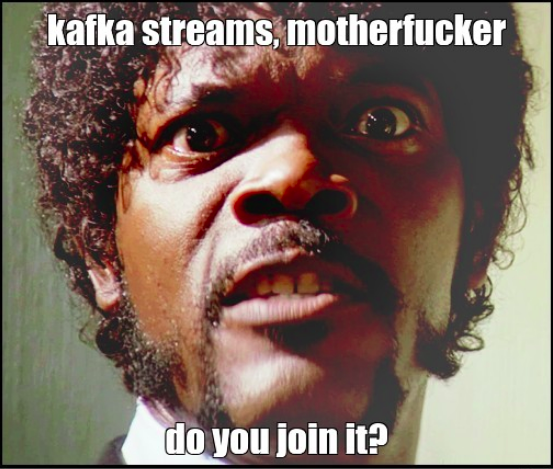

In [19]:
val df_join_test = spark.read.parquet("../data/parquet/df_join_test/")
df_join_test.show(1,100,true)
df_join_test.count()

parquet at cmd18.sc:1

1 / 1

show at cmd18.sc:2

1 / 1

-RECORD 0-----------------------------------------------------
 rowNum1           | 5830                                     
 feedback_TS       | 2018-02-12 10:40:58.933                  
 feedback_useID    | 3967689                                  
 feedback_objID    | 9853823                                  
 feedback          | [Ignored]                                
 membership_status | U                                        
 rowNum2           | 2163                                     
 content_TS        | 2018-01-01 09:50:18                      
 content_objID     | 9853823                                  
 applicationId     | 0                                        
 authorId          | 648717                                   
 numCompanions     | 0                                        
 numPhotos         | 2                                        
 numPolls          | 0                                        
 numSymbols        | 10                                

count at cmd18.sc:3

7 / 7

count at cmd18.sc:3

1 / 1

df_join_test: DataFrame = [rowNum1: bigint, feedback_TS: timestamp ... 35 more fields]
res18_2: Long = 2878L

<br>**Добавим процессинг фичей, протестируем на сохраненном датафрейме df_join_test, в случае успеха прикрутим на стрим**

In [20]:

val TARGET = "label"
val IDs = Array("feedback_useID", "feedback_objID")
val Out = Array("probability", "prediction")


TARGET: String = "label"
IDs: Array[String] = Array("feedback_useID", "feedback_objID")
Out: Array[String] = Array("probability", "prediction")

In [21]:
// ====================================================================
def get_features(df: DataFrame, IDs: Array[String]) : DataFrame = {
  
    val gen_cols = IDs.map(col) ++ Array(
        array_contains($"feedback", "Liked")     cast "int" as "label",
        
        datediff($"feedback_TS", $"content_TS") as "diffTS",
        
        (coalesce($"birth_date", lit(-999999)) as "birth_date"),
        (coalesce($"gender", lit(0)) === lit(1)) cast "int" as "gender",
        
        array_contains($"feedback", "Commented") cast "int" as "fb_commented",
        array_contains($"feedback", "Viewed")    cast "int" as "fb_viewed",
        array_contains($"feedback", "ReShared")  cast "int" as "fb_reshared",
        array_contains($"feedback", "Clicked")   cast "int" as "fb_clicked",        
        
        $"numCompanions",
        $"numPhotos",
        $"numPolls",
        $"numSymbols",
        $"numTokens",
        $"numVideos",
        $"totalVideoLength" as "lenVideos",
        
        concat_ws(" ", 
                  concat(lit("mstatus_"), lower($"membership_status")), 
                  lower($"objectType"), 
                  lower(concat_ws(" ", $"options")), 
                  lower($"ownerType"), 
                  lower($"platform")
                  ) 
        as "str_stack")
    
    df.select(gen_cols: _*)
   
}
// ====================================================================

defined function get_features

In [22]:

val df_join_test1 = get_features(df_join_test, IDs)
df_join_test1.show(1,100,true)

// ====================================================================

def transformPipe(df: DataFrame, Ignore: Array[String], tokenInputString: String, hashingNumFeatures: Int) = {
        
        val IGNORE = Ignore ++ Array(tokenInputString)
        
        val tokenizer = new Tokenizer().setInputCol(tokenInputString).setOutputCol("tokens")
        val hashing   = new HashingTF().setInputCol(tokenizer.getOutputCol).setOutputCol("rawFeatures").setNumFeatures(hashingNumFeatures)
        val idf       = new IDF().setInputCol(hashing.getOutputCol).setOutputCol("features_tfidf")
    
        val finInput  = df.columns.filterNot(Array(IGNORE: _*).contains) ++ Array(idf.getOutputCol)
        val assembler = new VectorAssembler().setInputCols(finInput).setOutputCol("features")
        val pipeline  = new Pipeline().setStages(Array(tokenizer, hashing, idf, assembler))
    
        pipeline
}
// ====================================================================

val pipeline = transformPipe(
    
    df = df_join_test1, 
    Ignore = IDs++Array(TARGET), 
    tokenInputString = "str_stack", 
    hashingNumFeatures=100
)

val transformModel = pipeline.fit(df_join_test1)

val featureTransformPath = "../model/featureTransform_test/"

transformModel.write.overwrite.save(featureTransformPath) 

// ====================================================================

def estimatorPipe(df: DataFrame, Ignore: Array[String], tokenInputString: String, hashingNumFeatures: Int) = {
        
        val IGNORE = Ignore ++ Array(tokenInputString)
        
        val tokenizer = new Tokenizer().setInputCol(tokenInputString).setOutputCol("tokens")
        val hashing   = new HashingTF().setInputCol(tokenizer.getOutputCol).setOutputCol("rawFeatures").setNumFeatures(hashingNumFeatures)
        val idf       = new IDF().setInputCol(hashing.getOutputCol).setOutputCol("features_tfidf")
    
        val finInput  = df.columns.filterNot(Array(IGNORE: _*).contains) ++ Array(idf.getOutputCol)
        val assembler = new VectorAssembler().setInputCols(finInput).setOutputCol("features")
        
        // val estimator = new LogisticRegression().setMaxIter(10).setRegParam(0.001)
        val estimator = new RandomForestClassifier().setLabelCol("label").setFeaturesCol(assembler.getOutputCol).setNumTrees(30)
    
        val pipeline  = new Pipeline().setStages(Array(tokenizer, hashing, idf, assembler, estimator))
    
        pipeline
}
// ====================================================================

val pipeline2 = estimatorPipe(
    
    df = df_join_test1, 
    Ignore = IDs++Array(TARGET), 
    tokenInputString = "str_stack", 
    hashingNumFeatures=100
)

val estimatorModel = pipeline2.fit(df_join_test1)

val featureEstimatorPath = "../model/estimatorTransform_test/"

estimatorModel.write.overwrite.save(featureEstimatorPath)  

// ====================================================================

val outCols = (IDs++Array(TARGET)++Array("features")++Out).map(col)

// val df_join_test2 = transformModel.transform(df_join_test1).select(outCols: _*)

// df_join_test2.show(1,100,true)
// df_join_test2.printSchema

// val df_features = df_join_test2.select(concat_ws("_", $"feedback_useID", $"feedback_objID", $"label") as "key", $"features" cast "string" as "value")

// df_features.show
// df_features.printSchema


val df_join_test3 = estimatorModel.transform(df_join_test1).select(outCols: _*)
df_join_test3.show(10) //.show(1,100,true)
df_join_test3.printSchema


show at cmd21.sc:2

1 / 1

-RECORD 0---------------------------------------------------------------------------------------
 feedback_useID | 3967689                                                                       
 feedback_objID | 9853823                                                                       
 label          | 0                                                                             
 diffTS         | 42                                                                            
 birth_date     | 4536                                                                          
 gender         | 0                                                                             
 fb_commented   | 0                                                                             
 fb_viewed      | 0                                                                             
 fb_reshared    | 0                                                                             
 fb_clicked     | 0           

treeAggregate at IDF.scala:54

7 / 7

treeAggregate at IDF.scala:54

2 / 2

runJob at SparkHadoopWriter.scala:78

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

parquet at IDF.scala:169

1 / 1

parquet at IDF.scala:169

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

treeAggregate at IDF.scala:54

7 / 7

treeAggregate at IDF.scala:54

2 / 2

first at VectorAssembler.scala:200

1 / 1

take at Classifier.scala:111

7 / 7

take at Classifier.scala:111

1 / 1

take at DecisionTreeMetadata.scala:112

1 / 1

count at DecisionTreeMetadata.scala:118

7 / 7

flatMap at RandomForest.scala:919

7 / 7

collectAsMap at RandomForest.scala:922

7 / 7

mapPartitions at RandomForest.scala:538

7 / 7

collectAsMap at RandomForest.scala:557

7 / 7

mapPartitions at RandomForest.scala:538

7 / 7

collectAsMap at RandomForest.scala:557

7 / 7

mapPartitions at RandomForest.scala:538

7 / 7

collectAsMap at RandomForest.scala:557

7 / 7

mapPartitions at RandomForest.scala:538

7 / 7

collectAsMap at RandomForest.scala:557

7 / 7

mapPartitions at RandomForest.scala:538

7 / 7

collectAsMap at RandomForest.scala:557

7 / 7

first at RandomForestClassifier.scala:145

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

parquet at IDF.scala:169

1 / 1

parquet at IDF.scala:169

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

runJob at SparkHadoopWriter.scala:78

1 / 1

parquet at treeModels.scala:402

4 / 4

parquet at treeModels.scala:407

4 / 4

first at VectorAssembler.scala:200

1 / 1

show at cmd21.sc:88

1 / 1

+--------------+--------------+-----+--------------------+--------------------+----------+
|feedback_useID|feedback_objID|label|            features|         probability|prediction|
+--------------+--------------+-----+--------------------+--------------------+----------+
|       3967689|       9853823|    0|(114,[0,1,8,10,31...|[0.76295729882050...|       0.0|
|      10486914|        304539|    0|(114,[0,1,6,10,11...|[0.83110422544646...|       0.0|
|      10486914|        304539|    0|(114,[0,1,6,10,11...|[0.83110422544646...|       0.0|
|      15279759|        304539|    0|(114,[0,1,10,11,1...|[0.85572133845098...|       0.0|
|       2252610|        304539|    0|(114,[0,1,10,11,1...|[0.84925373461035...|       0.0|
|       2856396|        304539|    1|(114,[0,1,6,10,11...|[0.82799770695683...|       0.0|
|        890127|        304539|    0|(114,[0,1,10,11,1...|[0.84925373461035...|       0.0|
|       9387417|        304539|    0|(114,[0,1,6,10,11...|[0.80455013497753...|       0.0|

df_join_test1: DataFrame = [feedback_useID: string, feedback_objID: string ... 16 more fields]
defined function transformPipe
pipeline: Pipeline = pipeline_56c0a2f39f7a
transformModel: PipelineModel = pipeline_56c0a2f39f7a
featureTransformPath: String = "../model/featureTransform_test/"
defined function estimatorPipe
pipeline2: Pipeline = pipeline_e8c927523019
estimatorModel: PipelineModel = pipeline_e8c927523019
featureEstimatorPath: String = "../model/estimatorTransform_test/"
outCols: Array[Column] = Array(
  feedback_useID,
  feedback_objID,
  label,
  features,
  probability,
  prediction
)
df_join_test3: DataFrame = [feedback_useID: string, feedback_objID: string ... 4 more fields]

In [23]:
val metric = new BinaryClassificationEvaluator().setLabelCol("label").setRawPredictionCol("prediction")
val rocauc = metric.evaluate(df_join_test3)

map at BinaryClassificationEvaluator.scala:81

7 / 7

sortByKey at BinaryClassificationMetrics.scala:155

7 / 7

combineByKey at BinaryClassificationMetrics.scala:154

7 / 7

collect at BinaryClassificationMetrics.scala:191

2 / 2

collect at SlidingRDD.scala:78

4 / 4

aggregate at AreaUnderCurve.scala:45

3 / 3

metric: BinaryClassificationEvaluator = binEval_92bae09e4340
rocauc: Double = 0.5007961783439491

<br>**Добавим стадию процессинга на стрим - обученный трансформер у нас получен на предыдущей итерации**
<br>```см. val loadedTransformModel = PipelineModel.read.load(featureTransformModelPath))```

In [24]:
val TARGET = "label"
val IDs = Array("feedback_useID", "feedback_objID")
val Out = Array("probability", "prediction")

val outCols = (IDs++Array(TARGET)++Array("features")++Out).map(col)

val featureTransformModelPath = "../model/featureTransform_test/"
val loadedFeatureModel = PipelineModel.read.load(featureTransformModelPath)

val estimatorTransformModelPath = "../model/estimatorTransform_test/"
val loadedEstimatorModel = PipelineModel.read.load(featureTransformModelPath)


first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

parquet at IDF.scala:180

1 / 1

head at IDF.scala:182

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

parquet at IDF.scala:180

1 / 1

head at IDF.scala:182

1 / 1

first at ReadWrite.scala:615

1 / 1

first at ReadWrite.scala:615

1 / 1

TARGET: String = "label"
IDs: Array[String] = Array("feedback_useID", "feedback_objID")
Out: Array[String] = Array("probability", "prediction")
outCols: Array[Column] = Array(
  feedback_useID,
  feedback_objID,
  label,
  features,
  probability,
  prediction
)
featureTransformModelPath: String = "../model/featureTransform_test/"
loadedFeatureModel: PipelineModel = pipeline_56c0a2f39f7a
estimatorTransformModelPath: String = "../model/estimatorTransform_test/"
loadedEstimatorModel: PipelineModel = pipeline_56c0a2f39f7a

In [25]:
val df_join1 = get_features(df_join, IDs)
df_join1.printSchema

root
 |-- feedback_useID: string (nullable = true)
 |-- feedback_objID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- diffTS: integer (nullable = true)
 |-- birth_date: integer (nullable = false)
 |-- gender: integer (nullable = false)
 |-- fb_commented: integer (nullable = true)
 |-- fb_viewed: integer (nullable = true)
 |-- fb_reshared: integer (nullable = true)
 |-- fb_clicked: integer (nullable = true)
 |-- numCompanions: long (nullable = true)
 |-- numPhotos: long (nullable = true)
 |-- numPolls: long (nullable = true)
 |-- numSymbols: long (nullable = true)
 |-- numTokens: long (nullable = true)
 |-- numVideos: long (nullable = true)
 |-- lenVideos: long (nullable = true)
 |-- str_stack: string (nullable = false)



df_join1: DataFrame = [feedback_useID: string, feedback_objID: string ... 16 more fields]

In [35]:
def createConsoleSink(df: DataFrame, trunc: Boolean) = {
    df
    .writeStream
    .format("console")
    .trigger(Trigger.ProcessingTime("60 seconds"))
    .option("truncate", trunc)
    .option("numRows", "10")
}

val sink = createConsoleSink(df_join1.select("feedback_useID","feedback_objID", "label", "diffTS","str_stack"), false).start().awaitTermination(100000)

start at cmd34.sc:10

4 / 4

start at cmd34.sc:10

200 / 200

-------------------------------------------
Batch: 0
-------------------------------------------
+--------------+--------------+-----+------+---------+
|feedback_useID|feedback_objID|label|diffTS|str_stack|
+--------------+--------------+-----+------+---------+
+--------------+--------------+-----+------+---------+



start at cmd34.sc:10

4 / 4

start at cmd34.sc:10

1 / 1

start at cmd34.sc:10

1 / 1

start at cmd34.sc:10

200 / 200

-------------------------------------------
Batch: 1
-------------------------------------------
+--------------+--------------+-----+------+-------------------------------------------------------------------------------------+
|feedback_useID|feedback_objID|label|diffTS|str_stack                                                                            |
+--------------+--------------+-----+------+-------------------------------------------------------------------------------------+
|1379637       |1370701       |0    |38    |mstatus_u photo has_text is_part_of_album has_detected_text group_open web           |
|1379637       |1370701       |0    |38    |mstatus_u photo has_text is_part_of_album has_detected_text group_open web           |
|2567736       |26473500      |0    |46    |mstatus_u post has_text has_photos is_part_of_topic group_open_official other        |
|5344344       |10918519      |1    |35    |mstatus_u post has_text has_photos is_part_of_topic group_open_official a

defined function createConsoleSink
sink: Boolean = false

In [36]:
killAll()

Stopped KafkaV2[Subscribe[feedback_topic_test]]


In [37]:
val df_join2 = loadedEstimatorModel.transform(df_join1).select(outCols: _*)

: 

In [61]:
// org.apache.spark.sql.AnalysisException: Queries with streaming sources must be executed with writeStream.start();;
// kafka

In [ ]:


// val df_features = (
//     loadedTransformModel
//     .transform(
//         get_features(df_join, IDs)
//     )
//     .select(outCols: _*)
//     .select(
//         concat_ws("_", $"feedback_useID", $"feedback_objID", $"label") as "key", 
//         $"features" cast "string" as "value"
//     )
// )

// val sink2 = createConsoleSink(df_features).start()

In [40]:
killAll()

In [41]:
spark.catalog.clearCache()
spark.close()
spark.stop()

In [ ]:
// val kafkaConsumerConf = Map(
//     "kafka.bootstrap.servers" -> "172.27.1.16:9092",
//     "enable.auto.commit"      -> "false",
//     "auto.commit.interval.ms" -> "31536000000",
//     "auto.offset.reset"       -> "earliest",
//     "startingOffsets"         -> "earliest"
// )

In [38]:
// val ds = df_features.wr
//   .writeStream
//   .format("kafka")
//   .option("kafka.bootstrap.servers", "172.27.1.16:9092")
//   .option("topic", "features_test")
//   .start()

In [ ]:
// вернем обработанный датафрейм в кафку - специальный топик features

In [ ]:
// val ds = df
//   .selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")
//   .writeStream
//   .format("kafka")
//   .option("kafka.bootstrap.servers", "host1:port1,host2:port2")
//   .option("topic", "topic1")
//   .start()

In [ ]:
// df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")
//   .write
//   .format("kafka")
//   .option("kafka.bootstrap.servers", "host1:port1,host2:port2")
//   .option("topic", "topic1")
//   .save()

In [ ]:
// import org.apache.spark.mllib.regression.StreamingLinearRegressionWithSGD

// val trainingData = ssc.textFileStream(args(0)).map(LabeledPoint.parse).cache()
// val testData = ssc.textFileStream(args(1)).map(LabeledPoint.parse)

// val numFeatures = 3
// val model = new StreamingLinearRegressionWithSGD()
//   .setInitialWeights(Vectors.zeros(numFeatures))

// model.trainOn(trainingData)
// model.predictOnValues(testData.map(lp => (lp.label, lp.features))).print()

// ssc.start()
// ssc.awaitTermination()

In [39]:
df_userinfo_test.unpersist()

res38: Dataset[Row] = [useID: int, create_date: bigint ... 12 more fields]

<br><br> **Попробуем заджойнить два стрима, частично записать часть данных в батч (для последующего обучения) - FULL mode (на всех данных, с добавление фичей) - PARQUET sink**

In [5]:
val df_userinfo = (
    spark.read.parquet("../data/processed/stg_userinfo/userinfo.parquet")
    .withColumnRenamed("userId","useID")
    .cache
)

df_userinfo.count()
df_userinfo.show(5)


parquet at cmd4.sc:2

1 / 1

count at cmd4.sc:7

4 / 4

count at cmd4.sc:7

1 / 1

show at cmd4.sc:8

1 / 1

show at cmd4.sc:8

3 / 3

+-----+-------------+----------+------+------+-----------+-----------+---------+----------+---------+------------+-------------+----------------+------+
|useID|  create_date|birth_date|gender|status| ID_country|ID_Location|is_active|is_deleted|is_abused|is_activated|change_datime|is_semiactivated|region|
+-----+-------------+----------+------+------+-----------+-----------+---------+----------+---------+------------+-------------+----------------+------+
|    3|1182840899490|      2216|     2|   192|10414533690|     425758|        1|         0|        0|           1|1448991398527|               0|     2|
|    6|1182841583650|     -4766|     2|   128|10414533690|    3683727|        1|         0|        0|           1|1500102484507|               0|    50|
|    9|1182841766247|      4293|     2|   192|10414533690|    3385314|        1|         0|        0|           1|1446451973670|               0|     1|
|   12|1182842289720|     -1000|     2|   192|10414533690|    3031192|        1|  

df_userinfo: Dataset[Row] = [useID: int, create_date: bigint ... 12 more fields]
res4_1: Long = 4362156L

In [13]:
spark.catalog.clearCache()
spark.close()
spark.stop()

In [14]:
"du -h -s ../data/checkpoint/df_join_batch" !

36M	../data/checkpoint/df_join_batch


res13: Int = 0

In [15]:
"du -h -s ../data/parquet/df_join_batch" !

3.3M	../data/parquet/df_join_batch


res14: Int = 0

In [16]:
"rm -rf ../data/checkpoint/df_join_batch" !

res15: Int = 0

In [17]:
"rm -rf ../data/parquet/df_join_batch" !

res16: Int = 0

### **Чтение из kafka-топика** `text_topic`  *(spark-api)* 

**https://jaceklaskowski.gitbooks.io/mastering-kafka-streams/content/kafka-streams-scala.html**

In [ ]:
// props.put(ConsumerConfig.ENABLE_AUTO_COMMIT_CONFIG, "false"); props.put(ConsumerConfig.AUTO_OFFSET_RESET_CONFIG, "earliest");

In [ ]:
// Almond не умеет подключаться к удаленному кластеру - только если он не развернут на Yarn`е или еще как-то, хз
// spark-master: 172.27.1.10
// .master("spark://172.27.1.10:7077")

In [ ]:
// Если топик не вычитывается from-beginning - попробовать рестартануть кернел ноутбука

// val spark = {
//   NotebookSparkSession.builder()
//     .master("local[*]")
//     .config("spark.executor.instances", "2")
//     .config("spark.executor.memory", "2g")
//     .getOrCreate()
// }

// import spark.implicits._

In [ ]:
// val df = spark
//   .readStream
//   .format("kafka")
//   .option("kafka.bootstrap.servers", "172.27.1.16:9092")
//   .option("subscribe", "content_topic")
// //   .option("enable.auto.commit", "false")
//   .option("auto.offset.reset","latest")
//   .option("startingOffsets", "earliest")
// //   .option("endingOffsets", "latest")
//   .load()
//   .select($"value" cast "string")

// def createConsoleSink(df: DataFrame) = {
//     df
//     .writeStream
//     .format("console")
//     .trigger(Trigger.ProcessingTime("10 seconds"))
//     .option("truncate", "false")
//     .option("numRows", "10")
// }

// val sink = createConsoleSink(df)
// val sq = sink.start()


In [ ]:
// sq.awaitTermination()

In [ ]:
// killAll()

In [ ]:
// spark.catalog.clearCache()
// spark.close()
// spark.stop()

### **Чтение из тестового потока** `rate`  *(spark-api)* 

In [ ]:
// spark-master: 172.27.1.10

val spark = {
  AmmoniteSparkSession.builder()
    .master("local[*]")
    .config("spark.executor.instances", "1")
    .config("spark.executor.memory", "1g")
    .getOrCreate()
}

import spark.implicits._

In [ ]:
val sdf = spark.readStream.format("rate").load

sdf.isStreaming
sdf.printSchema
sdf.explain(true)

def createConsoleSink(df: DataFrame) = {
    df
    .writeStream
    .format("console")
    .trigger(Trigger.ProcessingTime("5 seconds"))
    .option("truncate", "false")
    .option("numRows", "5")
}

val sink = createConsoleSink(sdf)
val sq = sink.start()


In [ ]:
sq.awaitTermination()

In [ ]:
killAll()

In [ ]:
spark.catalog.clearCache()
spark.close()
spark.stop()